This notebook is a step by step guide about how to train a deep neural network (DNN) in the DeepDeconv framework.

In [1]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import keras.utils

Using TensorFlow backend.


In [2]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))


[[22. 28.]
 [49. 64.]]


In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
tf.__path__

['/local/home/fsureau/miniconda3/lib/python3.6/site-packages/tensorflow',
 '/local/home/fsureau/miniconda3/lib/python3.6/site-packages/tensorflow/python/estimator/api',
 '/local/home/fsureau/miniconda3/lib/python3.6/site-packages/tensorflow/_api/v1']

In [2]:
from DeepDeconv.deepnetFCS.DeconvNet import DeconvNet

In [3]:
from deepnetFCS.DeconvNet_custom import UNet2D
nb_scales = 2 #4
nb_layers_per_block =  [2,2] #[2,2]#,2] #[4,5,6,7]
nb_filters=8
activation_function= 'relu' #'swish'
resNet=True
layer_string='layer{0}'.format(nb_layers_per_block[0])
for k in range(1,len(nb_layers_per_block)):
    layer_string+='x{0}'.format(nb_layers_per_block[k])
network_name='UNet2D_FCS_sc{0}_{1}_{2}_filt{3}'.format(nb_scales,layer_string,activation_function,nb_filters)
if resNet:
    network_name+='_resNet'

print("Network Name:",network_name)
    
dnn = UNet2D(network_name = network_name, img_rows = 96, img_cols = 96, model_file='', verbose=True,
                filters=nb_filters,nb_scales=nb_scales, nb_layers_per_block=nb_layers_per_block, 
             activation_function=activation_function,resNet=resNet)


Network Name: UNet2D_FCS_sc2_layer2x2_relu_filt8_resNet
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 8)    0           batch_normalization_1[0][0]      
_____________________________________________________

In [4]:
from keras.utils import plot_model
plot_model(dnn.model, to_file='{0}.png'.format(network_name),show_shapes=True)

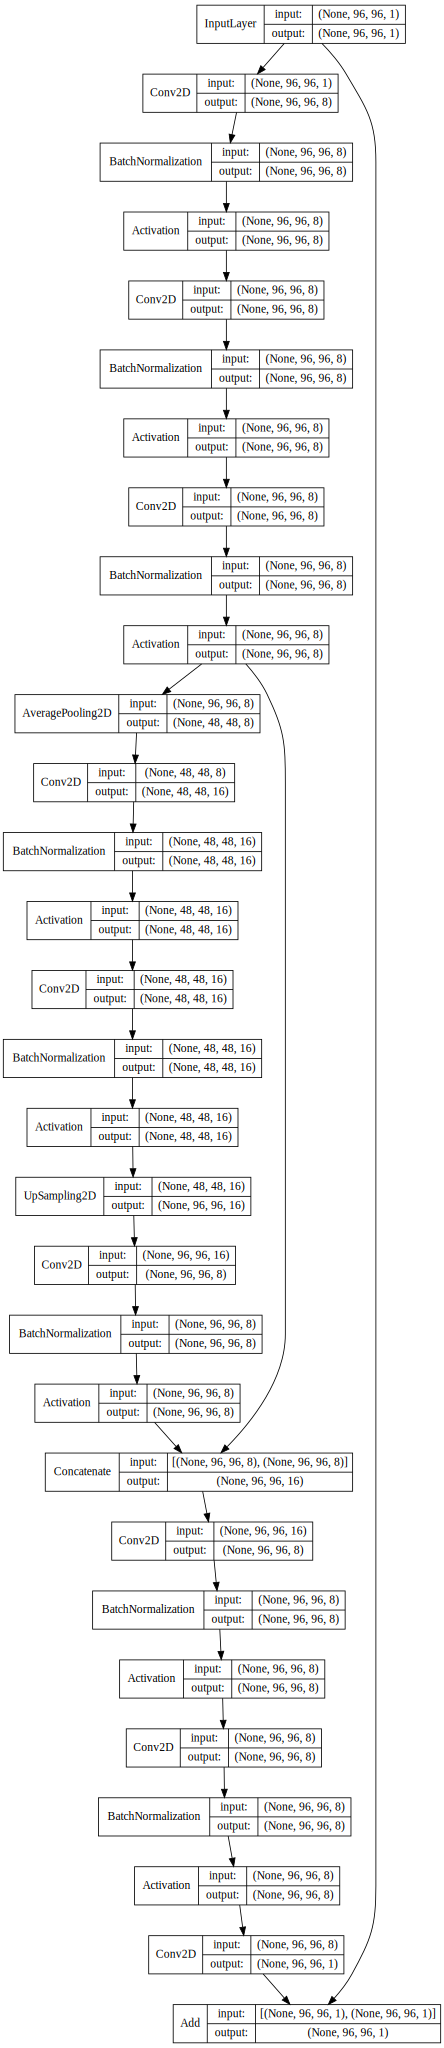

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

pydot_obj=model_to_dot(dnn.model,show_shapes=True,show_layer_names=False)
SVG(pydot_obj.create(prog='dot', format='svg'))

In [ ]:
from astropy.io import fits as fits
from matplotlib import pyplot as plt
#Input the directory containing the fits file
data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/'

#Retrieves the list of all the files
import glob

gal_files = glob.glob(data_directory+'image-0*-0.fits')
gal_files.sort()
print(gal_files)
ff=fits.open(gal_files[0])

['/data/DeepDeconv/data/vsc_euclidpsfs/image-000-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-001-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-002-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-003-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-004-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-005-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-006-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-007-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-008-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-009-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-010-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-011-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-012-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-013-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-014-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-015-0.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/image-016-0.fits', '/data/DeepDeconv/data/vsc_euc

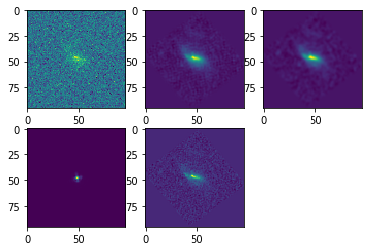

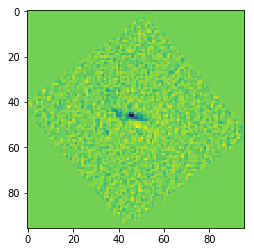

In [ ]:

plt.figure()
for k in range(5):
    plt.subplot(2,3,k+1),plt.imshow(ff[k].data[0:96,0:96])
#HDU 0: noisy
#HDU 1: noise free convolved with euclid PSF
#HDU 2: noise free convolved with large PSF (gauss 0.15 FWHM)
#HDU 3: euclid PSF
#HDU 4: noise free convolved with target PSF (gauss 0.07 FWHM)
plt.figure()
plt.imshow(ff[1].data[0:96,0:96]-ff[4].data[0:96,0:96])

In [ ]:
#SNR = [20,100]
SNR=100
noiseless_img_hdu = 1
targets_hdu = 4
psf_hdu = 3
deconv_mode = 'TIKHONOV'

#Train with the image-000-0.fits as validation and all the other files as training set
dnn.train_generator(gal_files[1:3], gal_files[0], epochs=4, batch_size=32,
                        nb_img_per_file=10000, validation_set_size=1000,
                        noise_std=None, SNR=SNR, model_file='',
                        noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
                        image_dim=96, image_per_row=100,
                        deconv_mode=deconv_mode)
#The train_generator is:
#1) running get_batch_from_fits for validation data: read files, deconv if necessary, return as [ngal,X2D,Y2D,1]
#2) setting a checkpoint for model, saving the model if lower validation loss
#3) using a generator function to obtain dynamic batches: dynamic_batches 
#   that I modified because it was assuming nb_img_per_file to be 10000 (hardcoded)
#4) running fit_generator with logging and checkpoint callbacks 

#I modified 


Model will be saved at /home/fsureau/programs/DeepDeconv/UNet2D_FCS_sc2_layer2x2_relu_filt8_resNet.hdf5
Memory usage for the model + one batch (GB): 0.226000


/home/fsureau/programs/DeepDeconv/deepnet/DeepNet.py:133: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=4, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=626)`
  callbacks=[model_checkpoint, LoggingCallback(filetxt=logfile, log=write_log)])


Epoch 1/4
626/626 [==============================] - 831s 1s/step - loss: 0.0570 - val_loss: 0.0016

Epoch 00001: val_loss improved from inf to 0.00160, saving model to UNet2D_FCS_sc2_layer2x2_relu_filt8_resNet.hdf5
2019-01-08_10:26:08 - Epoch: 1, val_loss: 0.001599, loss: 0.057137
Epoch 2/4
280/626 [============>.................] - ETA: 14:40 - loss: 0.0014